# New Notebook !

In [1]:
# Scientific libraries
import numpy as np
import scipy


# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook


# Creating alias for magic commands
%alias_magic t time

# LPPview Clasees
from LPPview.Classes.LPPic_oneD import oneD
from LPPview.Classes.LPPic_fields import field as Field
from LPPview.Classes.LPPic_histogram import histo as Distrib
from LPPview.Classes.LPPic_temporal import History

from sheath_fluid import Plasma, Plasma_ne


import astropy.units as u
import plasmapy as ppy

from scipy.optimize import fsolve
m_e = ppy.constants.m_e
mi = ppy.constants.m_p*40
qe = ppy.constants.e.si.value

from tqdm import tqdm_notebook as tqdm
import numba

import json
from scipy.stats import linregress

from scipy.ndimage import gaussian_filter1d as smoot

Created `%t` as an alias for `%time`.
Created `%%t` as an alias for `%%time`.


In [2]:
def eq(g, chi, f=1):
    return (1 + g*chi )*(1+chi)**((g-1)/2) - (2*f*np.pi*g*m_e/mi)**((g-1)/2)
    
def dphi(g, f=1):
    chi_initial_guess = 0.5
    chi_solution = fsolve(lambda c:eq(g,c,f), chi_initial_guess)[0]
    return -chi_solution*g/(g-1)

In [3]:
with open("NewPic1D.dat", 'r') as f:
    dataPIC = json.load(f)

$\gamma$ = 1.42, r=0.9998


Text(0.5, 0.98, 'PIC simulation results, P = 2.0 mTorr')

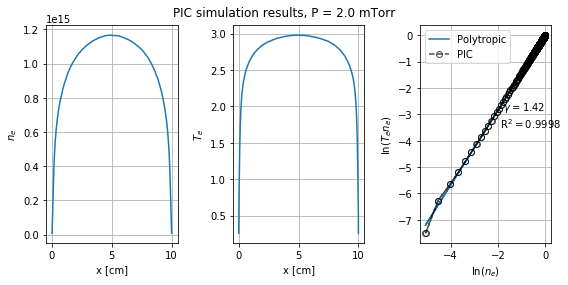

In [4]:
k = "1"
x, ne, Te, phi, Ji = [np.array(dataPIC[k][key]) for key in ["x", "ne", 'Te2', "phi", "Ji"]]
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(8,4))
ax1.plot(x, ne)
ax1.set_ylabel("$n_e$")
ax2.plot(x, Te)
ax2.set_ylabel("$T_e$")
ax3.set_ylabel("ln$(T_e n_e$)")
ax3.set_xlabel("ln$(n_e$)")
ax3.grid()

ln_ne = np.log(ne/ne.max())
ln_pe = np.log(ne*Te/(Te*ne).max())

gamma1, b, r, p, err = linregress(ln_ne[3:-3], ln_pe[3:-3])
gamma, b, r, p, err = linregress(ln_ne, ln_pe)
print(f"$\\gamma$ = {gamma:2.3}, r={r:2.4}")
ax3.plot(ln_ne, ln_ne*gamma + b, label="Polytropic")
ax3.plot(ln_ne, ln_pe, "o--k", label="PIC", markerfacecolor="none", alpha=0.7)
ax3.text(ln_ne[-10], ln_pe[-10], f"     $\gamma = {gamma:2.2f}$ \n    R$^2 = {r:1.4f}$")
ne0 = ne.max()*u.m**(-3)
Te0 = Te.max()*u.eV
L = 5*u.cm
ax3.legend()


for ax in [ax1, ax2]:
    ax.set_xlabel("x [cm]")
    ax.grid()
    
plt.tight_layout(rect=(0,0,1,0.99))
plt.suptitle("PIC simulation results, P = "+str(dataPIC[k]["Pn"])+" mTorr")

In [5]:
p = Plasma_ne(Te0 = Te0, ne0 = ne0, L=L, mi=40*u.Da, sigma=35801*u.s**(-1),
              gamma=gamma, ionization=2, Niter=2000 , verbose=False )

for _ in tqdm(range(20)):
    p.iterate()
print(p.p.sigma)
plasma1 = p.p

p = Plasma_ne(Te0 = Te0, ne0 = ne0, L=L, mi=40*u.Da, sigma=p.p.sigma,
              gamma=gamma1, ionization=2, Niter=2000 , verbose=False )

for _ in tqdm(range(20)):
    p.iterate()
print(p.p.sigma)
plasma2 = p.p

p = Plasma_ne(Te0 = Te0, ne0 = ne0, L=L, mi=40*u.Da, sigma=p.p.sigma,
              gamma=1, ionization=2, Niter=2000 , verbose=False )

for _ in tqdm(range(20)):
    p.iterate()
print(p.p.sigma)
plasma3 = p.p


35043.68095341953 1 / s



34999.90590255036 1 / s



29568.836251590696 1 / s


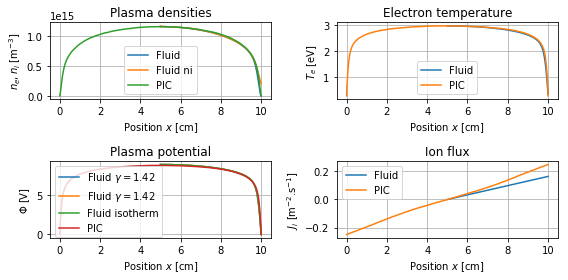

In [6]:
fig, axarr = plt.subplots(2,2,figsize=(8,4))
ax1, ax2, ax3, ax4 = axarr.flatten()
plasma = plasma1
xcm = plasma.x.to(u.cm).value + 5
ax1.plot(xcm, plasma.ne, label="Fluid")
ax1.plot(xcm, plasma.ni, label="Fluid ni")
ax1.plot(x, ne, label="PIC")
ax1.set_title("Plasma densities")
ax1.set_ylabel("$n_e, n_i$ [m$^{-3}$]")


ax2.plot(xcm, plasma.Te, label="Fluid")
ax2.plot(x, Te, label="PIC")
ax2.set_title("Electron temperature")
ax2.set_ylabel("$T_e$ [eV]")


for plama, n in zip([plasma1, plasma2, plasma3], [f" $\gamma = {gamma:1.2f}$",
                                               f" $\gamma = {gamma1:1.2f}$",
                                               " isotherm"]):
    pphi = plasma1.phi
    pphi -= pphi.min()

    ax3.plot(xcm, pphi, label="Fluid"+n)
    
ax3.plot(x, phi, label="PIC")
ax3.set_title("Plasma potential")
ax3.set_ylabel("$\\Phi$ [V]")

J = plasma.ni* plasma.vi*plasma.qe/2

ax4.plot(xcm, J, label="Fluid")
ax4.plot(x, Ji, label="PIC")
ax4.set_title("Ion flux")
ax4.set_ylabel("$J_i$ [m$^{-2}$.s$^{-1}$]")


for ax in axarr.flatten():
    ax.grid()
    ax.legend()
    ax.set_xlabel("Position $x$ [cm]")
    
plt.tight_layout()

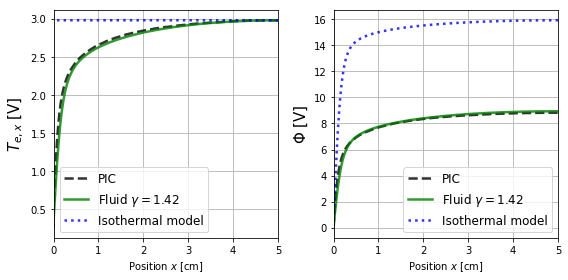

In [7]:
s = 2.5

alphaPIC = 0.8
fslegend = 12
fslabels = 15

fig, axarr = plt.subplots(1,2,figsize=(8,4))
ax2, ax1 = axarr.flatten()
plasma = plasma1
xcm = plasma.x.to(u.cm).value[::-1]

ax2.plot(x, Te,  '--k', label="PIC", linewidth=s,alpha = alphaPIC)

ax2.plot(xcm, plasma.Te, 'g', label="Fluid $\gamma=1.42$", linewidth=s, alpha = alphaPIC)
ax2.plot(xcm, plasma3.Te, ":b", label="Isothermal model", linewidth=s, alpha = alphaPIC)
# ax2.set_title("Electron temperature", fontsize=fslabels)
ax2.set_ylabel("$T_{e,x}$ [V]", fontsize=fslabels)

ax1.plot(x, phi, '--k', label="PIC", linewidth=s,alpha = alphaPIC)

pphi = plasma.phi
pphi -= pphi.min()

ax1.plot(xcm, pphi,  'g', label="Fluid $\gamma=1.42$", linewidth=s, alpha = alphaPIC)

pphi = plasma3.phi
pphi -= pphi.min()

ax1.plot(xcm, pphi, ":b", label="Isothermal model", linewidth=s, alpha = alphaPIC)

# ax1.set_title("Plasma potential", fontsize=fslabels)
ax1.set_ylabel("$\\Phi$ [V]", fontsize=fslabels)

for ax in axarr.flatten():
    ax.grid()
    ax.legend(fontsize=fslegend)
    ax.set_xlabel("Position $x$ [cm]")
    ax.set_xlim(0,5)
    
plt.tight_layout()

plt.savefig("/home/tavant/these/articles/anisothermal-sheath-model/figures/FluidComparison.pdf")

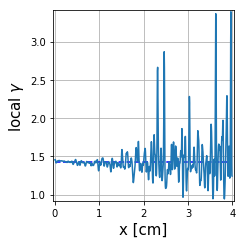

In [8]:
plt.figure(figsize=(3.5,3.5))
plt.margins(0.01)
nes = smoot(ne, 2)
Tes = smoot(Te, 2)
ln_ne = np.log(nes/nes.max())
ln_pe = np.log(nes*Tes/(Tes*nes).max())

xmax = 4
fslegend = 12
fslabels = 15

plt.plot(x[x<xmax], smoot(np.gradient(ln_pe[x<xmax], ln_ne[x<xmax]), 0.001))
plt.hlines([gamma,], 0, xmax, colors='b', linestyles="--")

plt.xlabel("x [cm]", fontsize=fslabels)
plt.ylabel(r"local $\gamma$", fontsize=fslabels)
plt.grid(f)
plt.tight_layout()

# ICP

In [9]:
with open("/home/tavant/these/articles/anisothermal-sheath-model/data/ICP_data.dat", 'r') as f:
    dataPIC = json.load(f)

$\gamma$ = 1.66, r=0.9924


Text(0.5, 0.98, 'PIC simulation results, P = 0.1 mTorr')

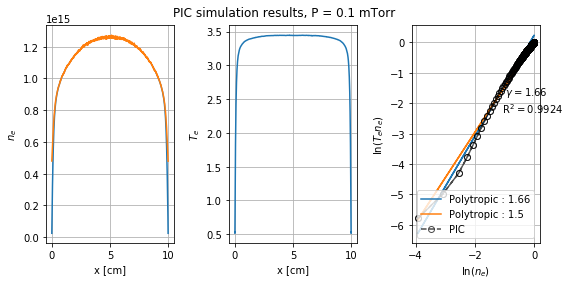

In [10]:
k = "0"
x, ne,ni, Te, phi, Ji = [np.array(dataPIC[k][key]) for key in ["x", "ne","ni", 'Te2', "phi", "Ji"]]
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(8,4))
ax1.plot(x, ne)
ax1.plot(x, ni)
ax1.set_ylabel("$n_e$")
ax2.plot(x, Te)
ax2.set_ylabel("$T_e$")
ax3.set_ylabel("ln$(T_e n_e$)")
ax3.set_xlabel("ln$(n_e$)")
ax3.grid()

ln_ne = np.log(ne/ne.max())
ln_pe = np.log(ne*Te/(Te*ne).max())

imax = 40
gamma, b, r, p, err = linregress(ln_ne[:imax], ln_pe[:imax])
istart = 1
gamma1, b1, r, p, err = linregress(ln_ne[istart:-istart], ln_pe[istart:-istart])
print(f"$\\gamma$ = {gamma:2.3}, r={r:2.4}")

ax3.plot(ln_ne, ln_ne*gamma + b, label="Polytropic : "+str(round(gamma,2)))
ax3.plot(ln_ne, ln_ne*gamma1 + b1, label="Polytropic : "+str(round(gamma1,2)))
ax3.plot(ln_ne, ln_pe, "o--k", label="PIC", markerfacecolor="none", alpha=0.7)
ax3.text(ln_ne[-10], ln_pe[-10], f"     $\gamma = {gamma:2.2f}$ \n    R$^2 = {r:1.4f}$")
ne0 = ne.max()*u.m**(-3)
Te0 = Te.max()*u.eV
L = 5*u.cm
ax3.legend()


for ax in [ax1, ax2]:
    ax.set_xlabel("x [cm]")
    ax.grid()
    
plt.tight_layout(rect=(0,0,1,0.99))
plt.suptitle("PIC simulation results, P = "+str(dataPIC[k]["Pn"])+" mTorr")

In [11]:

ln_ne = np.log(ne/ne.max())
ln_pe = np.log(ne*Te/(Te*ne).max())

imax = 200
gamma, b, r, p, err = linregress(ln_ne[:imax], ln_pe[:imax])
istart = 1
gamma1, b1, r, p, err = linregress(ln_ne[istart:-istart], ln_pe[istart:-istart])
print(f"$\\gamma$ sheath= {gamma:2.4}, r={r:2.4}")
print(f"$\\gamma$ whole = {gamma1:2.4}, r={r:2.4}")

$\gamma$ sheath= 1.598, r=0.9924
$\gamma$ whole = 1.496, r=0.9924


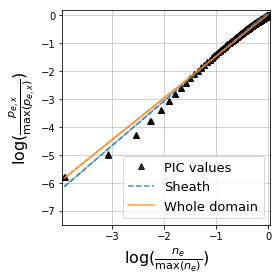

In [12]:
plt.figure(figsize=(4,4))

ax = plt.gca()
ax.plot(ln_ne, ln_pe, "k^",alpha=0.8, label ="PIC values")
ax.plot(ln_ne, b + gamma*ln_ne, "--",alpha=0.8, label ="Sheath")
ax.plot(ln_ne, b1 + gamma1*ln_ne, "-",alpha=0.8, label ="Whole domain")

ax.set_ylabel("log($\\frac{p_{e,x}}{\max(p_{e,x})}$)", fontsize=16)
ax.set_xlabel("log($\\frac{n_e}{\max(n_e)}$)", fontsize=16)
# ax.set_title("Polytropic process, p= "+str(p)+" mTorr", fontsize=19)

ax.grid(alpha=0.7)
ax.margins(0.01)
ax.legend(fontsize=13)
ax.set_ylim(bottom=-7.5)
plt.tight_layout()
plt.savefig("../figures/ICP_polyfit2.pdf")

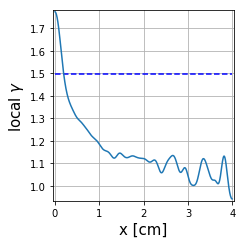

In [13]:
#plot
plt.figure(figsize=(3.5,3.5))
plt.margins(0.01)
nes = smoot(ne, 4)
Tes = smoot(Te, 4)
ln_ne = np.log(nes/nes.max())
ln_pe = np.log(nes*Tes/(Tes*nes).max())

xmax = 4
fslegend = 12
fslabels = 15

plt.plot(x[x<xmax], smoot(np.gradient(smoot(ln_pe[x<xmax],6), smoot(ln_ne[x<xmax],6)), 12))

plt.hlines([gamma1,], 0, xmax, colors='b', linestyles="--")

plt.xlabel("x [cm]", fontsize=fslabels)
plt.ylabel(r"local $\gamma$", fontsize=fslabels)
plt.grid(f)
plt.tight_layout()
plt.savefig("/home/tavant/these/articles/anisothermal-sheath-model/figures/local_gamma.pdf")

In [14]:
p = Plasma_ne(Te0 = Te0, ne0 = ne0, L=L, mi=40*u.Da, sigma=44959*u.s**(-1),
              gamma=gamma1, ionization=1, Niter=2000 , verbose=False )

for _ in tqdm(range(20)):
    p.iterate()
print(p.p.sigma)
plasma1 = p.p
p = Plasma_ne(Te0 = Te0, ne0 = ne0, L=L, mi=40*u.Da, sigma=46603*u.s**(-1),
              gamma=gamma, ionization=1, Niter=2000 , verbose=False )

for _ in tqdm(range(20)):
    p.iterate()
print(p.p.sigma)
plasma0 = p.p

p = Plasma_ne(Te0 = Te0, ne0 = ne0, L=L, mi=40*u.Da, sigma=36603*u.s**(-1),
              gamma=1, ionization=1, Niter=2000 , verbose=False )

for _ in tqdm(range(20)):
    p.iterate()
print(p.p.sigma)
plasma3 = p.p


44700.882852186856 1 / s



46126.486724748785 1 / s



36822.759749379125 1 / s


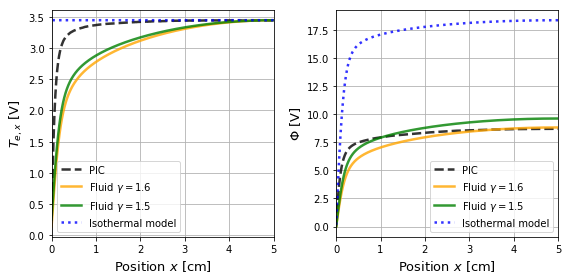

In [15]:
#the figure
s = 2.5

alphaPIC = 0.8
fslegend = 12
fslabels = 13

fig, axarr = plt.subplots(1,2,figsize=(8,4))
ax2, ax1 = axarr.flatten()
plasma = plasma1
xcm = plasma.x.to(u.cm).value[::-1]

ax2.plot(x, Te,  '--k', label="PIC", linewidth=s,alpha = alphaPIC)
ax2.plot(xcm, plasma0.Te, 'orange', label=f"Fluid $\gamma={round(plasma0.gamma,2)}$", linewidth=s, alpha = alphaPIC)

ax2.plot(xcm, plasma.Te, 'g', label=f"Fluid $\gamma={round(plasma.gamma,2)}$", linewidth=s, alpha = alphaPIC)
ax2.plot(xcm, plasma3.Te, ":b", label="Isothermal model", linewidth=s, alpha = alphaPIC)
# ax2.set_title("Electron temperature", fontsize=fslabels)
ax2.set_ylabel("$T_{e,x}$ [V]", fontsize=fslabels)

ax1.plot(x, phi, '--k', label="PIC", linewidth=s,alpha = alphaPIC)


pphi = plasma0.phi
pphi -= pphi.min()

ax1.plot(xcm, pphi, 'orange', label=f"Fluid $\gamma={round(plasma0.gamma,2)}$", linewidth=s, alpha = alphaPIC)

pphi = plasma.phi
pphi -= pphi.min()

ax1.plot(xcm, pphi,  'g', label=f"Fluid $\gamma={round(plasma.gamma,2)}$", linewidth=s, alpha = alphaPIC)



pphi = plasma3.phi
pphi -= pphi.min()

ax1.plot(xcm, pphi, ":b", label="Isothermal model", linewidth=s, alpha = alphaPIC)

# ax1.set_title("Plasma potential", fontsize=fslabels)
ax1.set_ylabel("$\\Phi$ [V]", fontsize=fslabels)

for ax in axarr.flatten():
    ax.grid()
    ax.legend(fontsize=10)
    ax.set_xlabel("Position $x$ [cm]", fontsize=fslabels)
    ax.set_xlim(0,5)
    
plt.tight_layout()

plt.savefig("/home/tavant/these/articles/anisothermal-sheath-model/figures/FluidComparisonICP.pdf")

NameError: name 'gammasheath' is not defined

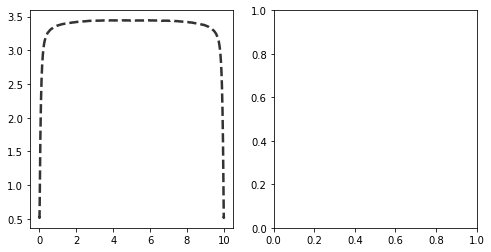

In [16]:
#the figure
s = 2.5

alphaPIC = 0.8
fslegend = 12
fslabels = 13

fig, axarr = plt.subplots(1,2,figsize=(8,4))
ax2, ax1 = axarr.flatten()
plasma = plasma1
xcm = plasma.x.to(u.cm).value[::-1]

ax2.plot(x, Te,  '--k', label="PIC", linewidth=s,alpha = alphaPIC)
ax2.plot(xcm, plasma0.Te, 'orange', label=f"Fluid $\gamma={round(gammasheath,2)}$", linewidth=s, alpha = alphaPIC)

ax2.plot(xcm, plasma3.Te, ":b", label="Isothermal model", linewidth=s, alpha = alphaPIC)
# ax2.set_title("Electron temperature", fontsize=fslabels)
ax2.set_ylabel("$T_e$ [V]", fontsize=fslabels)

ax1.plot(x, phi, '--k', label="PIC", linewidth=s,alpha = alphaPIC)


pphi = plasma0.phi
pphi -= pphi.min()

ax1.plot(xcm, pphi, 'orange', label=f"Fluid $\gamma={round(gammasheath,2)}$", linewidth=s, alpha = alphaPIC)


pphi = plasma3.phi
pphi -= pphi.min()

ax1.plot(xcm, pphi, ":b", label="Isothermal model", linewidth=s, alpha = alphaPIC)

# ax1.set_title("Plasma potential", fontsize=fslabels)
ax1.set_ylabel("$\\Phi$ [V]", fontsize=fslabels)

for ax in axarr.flatten():
    ax.grid()
    ax.legend(fontsize=10)
    ax.set_xlabel("Position $x$ [cm]", fontsize=fslabels)
    ax.set_xlim(0,5)
    
plt.tight_layout()

plt.savefig("/home/tavant/these/articles/anisothermal-sheath-model/figures/FluidComparisonICP_bis.pdf")